# First NSF

**Goal:** I just integrated the nflows modules into my experimental setup, so I want to 
1. Look at the loss function
2. Evaluate the HH variables
3. See how many trainings I need for a stable prediction

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import combinations

import matplotlib.pyplot as plt
from matplotlib import gridspec

import os
os.sys.path.append('../Flow-Models/')
from densityEstimate import *
from densityPlots import *

import torch
from torch.distributions import Normal

%load_ext autoreload
%autoreload 2

Running w/ conda env: don't import root packages.


**Load in the data**

In [2]:
subDir = 'data16_PFlow-FEB20-5jets'
tag = '_SM_2b_p_0.01'
seedTag = ''
prodTag = 'FEB20'
ntag = 2

lr, beta = 1e-3,1e-3
L,H,nb = 5,32,2
K,B = 8,3
lt,bt = 'random','rq-coupling'
p = 0
cols = ['log_pT_h1','log_pT_h2','eta_h1','eta_h2','log_dphi_hh']

In [3]:
s = f'm_h1>{126-45} & m_h1<{126+45} & m_h2>{116-45} & m_h2<{116+45}'
d = data(5, 16, prodTag, tag, ntag, s)

mask = (d.df.abs_deta_hh < 1.5) 
d.mlPrepare(mask,cols,N=-1)

../data/data16_PFlow-FEB20-5jets/df_SM_2b_p_0.01_2b.h5
Taking 52080 events from 52080 available for the training / validation set


In [4]:
seedTag

''

**Load in the model**

In [5]:
configDir = f'{subDir}{tag}_2b_detaCut{seedTag}'

In [6]:
ni = myNSF(configDir, lr,beta,cols,0,L,H,nb,K,B,lt,bt,p,
           load_model=True,modelBaseDir='../Flow-Models/models')

lr = 0.001, weight decay = 0.001, iter = 0, cols = ['log_pT_h1', 'log_pT_h2', 'eta_h1', 'eta_h2', 'log_dphi_hh']
Setting torch random seed 10
../Flow-Models/models/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut//nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_random_5_layers_H_32_2_blocks_K_8_B_3_lr_0.001_0.001_iter0/model.pt


**Look at the loss**

In [7]:
filename = f'{ni.modelDir}/loss_acc.json'
if os.path.exists(filename):

    with open(filename, 'r') as varfile:
        metrics = json.load(varfile)

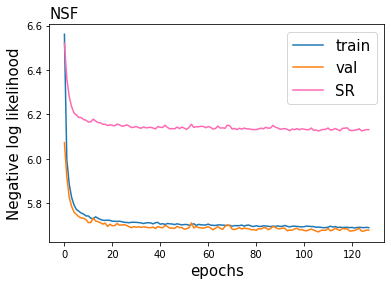

In [8]:
trainingMetric(metrics,title='NSF')#,figName=f'{figDir}/loss.pdf')

Woah - the loss is q high, I guess the model is overfitting?

**Look at the 5d correlation plot**

In [9]:
npi = RealNVP_Plots(ni,mode=1,save=False)

npi.figDir = 'figures/' + '/'.join(ni.modelDir.split('/')[3:])
npi.save=True

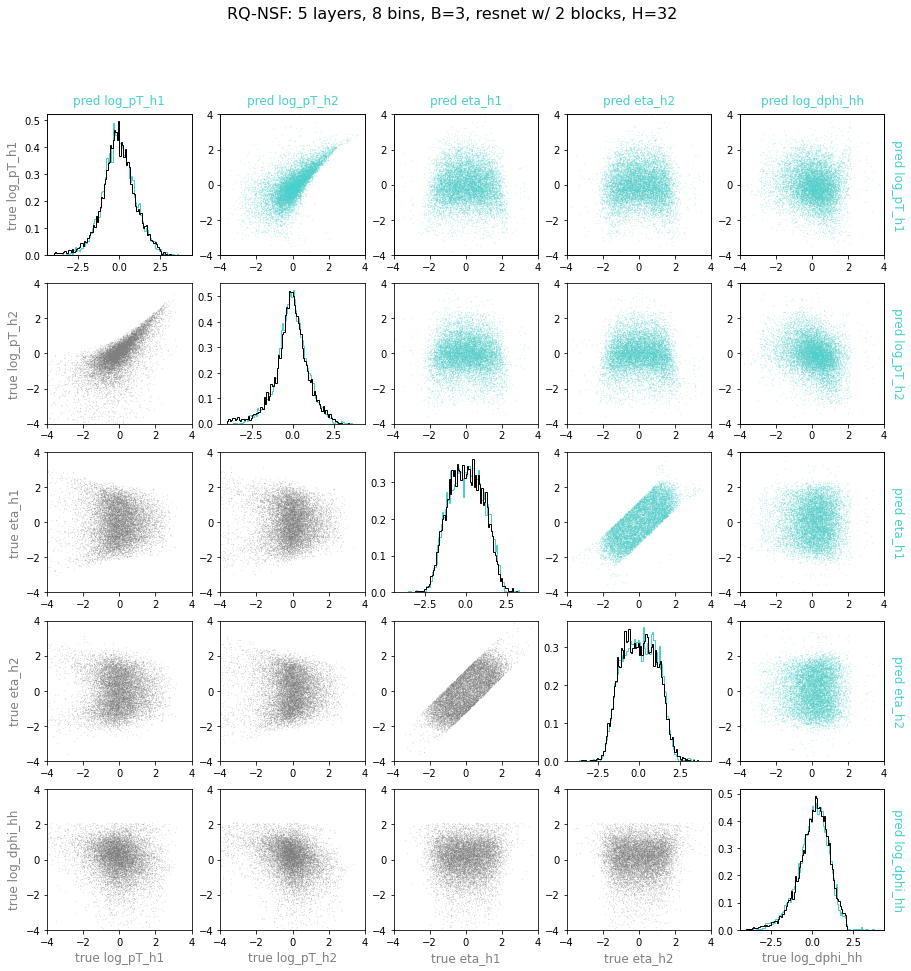

In [10]:
npi.plot_correlations(d.X_SR,d.Y_SR,'mediumturquoise',cols,
                      title= f'RQ-NSF: {L} layers, {K} bins, B={B}, resnet w/ {nb} blocks, H={H}')

**HH level variables**

In [11]:
df = d.df
mask = (df.kinematic_region==0) & (df.abs_deta_hh < 1.5)

In [12]:
nPreds = 10

(90,) (90,) (90,)
figures/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut//nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_random_5_layers_H_32_2_blocks_K_8_B_3_lr_0.001_0.001_iter0//dphi_hhSR


../Flow-Models/densityPlots.py:621: RuntimeWarning: divide by zero encountered in true_divide
  axb.errorbar(xx, n_pred/n_2b, np.sqrt(n_2b)/n_2b, fmt='.', color=color)
../Flow-Models/densityPlots.py:621: RuntimeWarning: invalid value encountered in true_divide
  axb.errorbar(xx, n_pred/n_2b, np.sqrt(n_2b)/n_2b, fmt='.', color=color)
../Flow-Models/densityPlots.py:621: RuntimeWarning: invalid value encountered in true_divide
  axb.errorbar(xx, n_pred/n_2b, np.sqrt(n_2b)/n_2b, fmt='.', color=color)


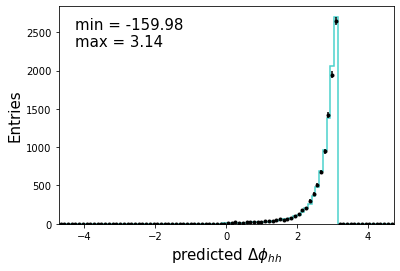

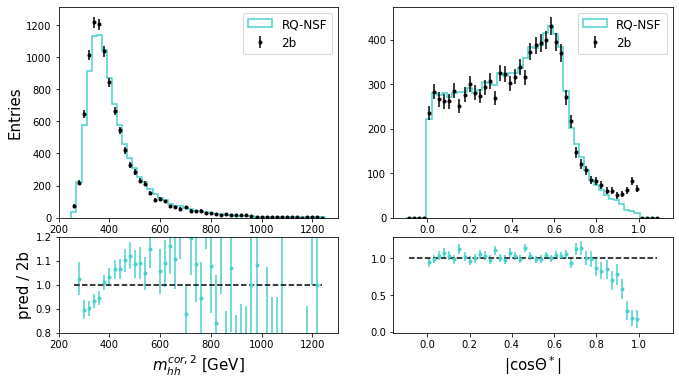

In [13]:
dfi = npi.pred_hh(d.X_SR,d.Y_SR,d.scalar,mask,df,nPreds=nPreds,cols=cols,color='mediumturquoise')

**Immediate Q:** How does this compare to the R-NVP that I have trained w/ the same data split?

In [14]:
L,H

(5, 32)

lr = 0.001, weight decay = 0.001, iter = 0, cols = ['log_pT_h1', 'log_pT_h2', 'eta_h2', 'eta_h1', 'log_dphi_hh']
Setting up a R-NVP model with 5 layers, hidden_dim=32
tensor([0., 1., 0., 1., 0.])
(90,) (90,) (90,)


../Flow-Models/densityPlots.py:621: RuntimeWarning: divide by zero encountered in true_divide
  axb.errorbar(xx, n_pred/n_2b, np.sqrt(n_2b)/n_2b, fmt='.', color=color)
../Flow-Models/densityPlots.py:621: RuntimeWarning: invalid value encountered in true_divide
  axb.errorbar(xx, n_pred/n_2b, np.sqrt(n_2b)/n_2b, fmt='.', color=color)
../Flow-Models/densityPlots.py:621: RuntimeWarning: invalid value encountered in true_divide
  axb.errorbar(xx, n_pred/n_2b, np.sqrt(n_2b)/n_2b, fmt='.', color=color)


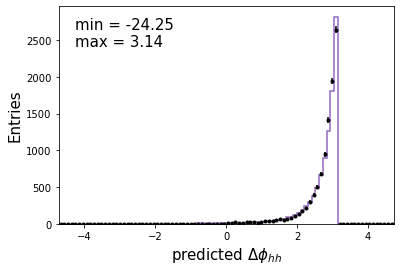

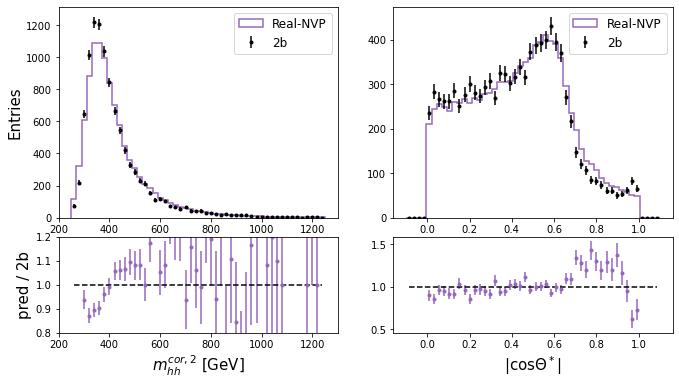

In [15]:
ri = RealNVP(configDir, lr, beta, 
             ['log_pT_h1','log_pT_h2','eta_h2','eta_h1','log_dphi_hh'], 
             0, L, H,
             load_model=True,modelBaseDir='../Flow-Models/models')

rpi = RealNVP_Plots(ri,save=False)

dfr = rpi.pred_hh(d.X_SR,d.Y_SR,d.scalar,mask,df,nPreds=nPreds,cols=cols,color='C4')

In [16]:
filename = f'{ri.modelDir}/loss_acc.json'
if os.path.exists(filename):

    with open(filename, 'r') as varfile:
        rmetrics = json.load(varfile)

**Next:** Do the generalized permutations help @ all?

In [17]:
nj= myNSF(f'{subDir}{tag}_2b_detaCut{seedTag}', lr,beta,cols,0,L,H,nb,K,B,'lu',bt,p,
           load_model=True,modelBaseDir='../Flow-Models/models')

lr = 0.001, weight decay = 0.001, iter = 0, cols = ['log_pT_h1', 'log_pT_h2', 'eta_h1', 'eta_h2', 'log_dphi_hh']
Setting torch random seed 10
../Flow-Models/models/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut//nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_5_layers_H_32_2_blocks_K_8_B_3_lr_0.001_0.001_iter0/model.pt


In [18]:
filename = f'{nj.modelDir}/loss_acc.json'
if os.path.exists(filename):

    with open(filename, 'r') as varfile:
        metrics2 = json.load(varfile)

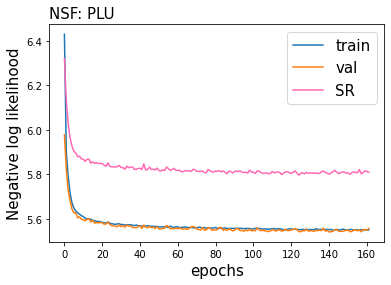

In [19]:
trainingMetric(metrics2,title='NSF: PLU')#,figName=f'{figDir}/loss.pdf')

In [20]:
npj = RealNVP_Plots(nj,mode=1,save=False)
npj.figDir = 'figures/' + '/'.join(nj.modelDir.split('/')[3:])
npj.save = True

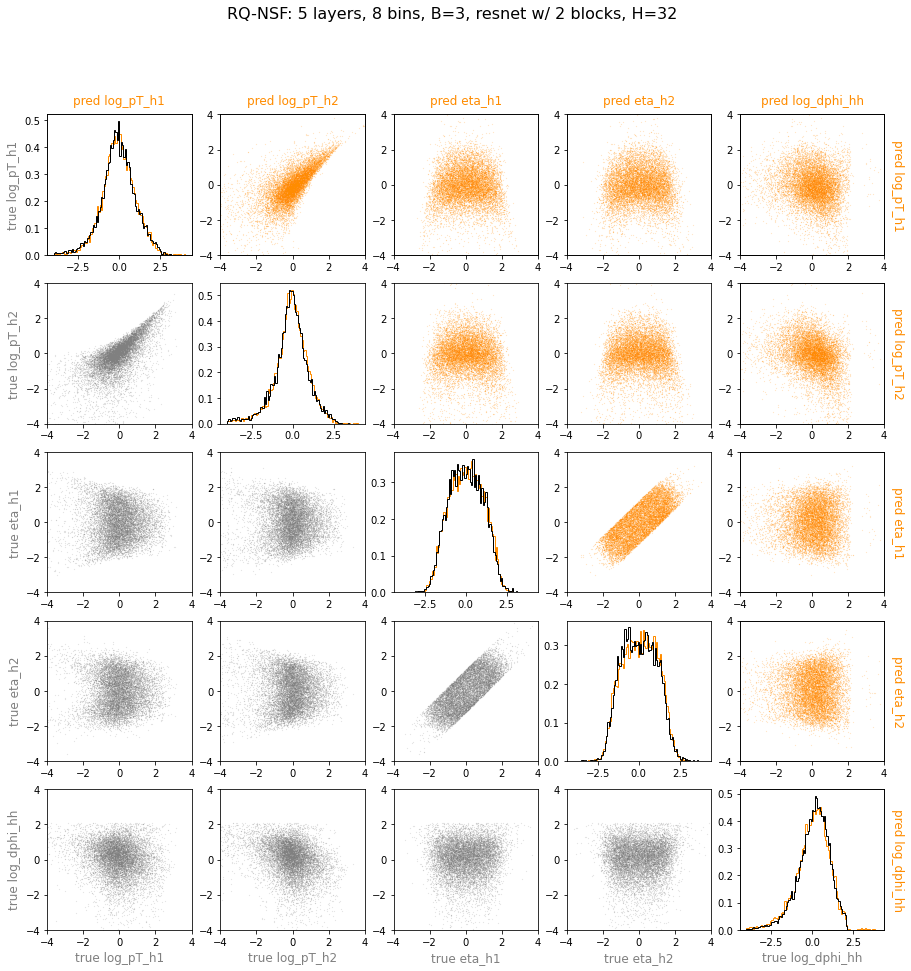

In [21]:
npj.plot_correlations(d.X_SR,d.Y_SR,'darkorange',cols,
                      title= f'RQ-NSF: {L} layers, {K} bins, B={B}, resnet w/ {nb} blocks, H={H}')

(90,) (90,) (90,)
figures/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut//nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_5_layers_H_32_2_blocks_K_8_B_3_lr_0.001_0.001_iter0//dphi_hhSR


../Flow-Models/densityPlots.py:621: RuntimeWarning: divide by zero encountered in true_divide
  axb.errorbar(xx, n_pred/n_2b, np.sqrt(n_2b)/n_2b, fmt='.', color=color)
../Flow-Models/densityPlots.py:621: RuntimeWarning: invalid value encountered in true_divide
  axb.errorbar(xx, n_pred/n_2b, np.sqrt(n_2b)/n_2b, fmt='.', color=color)
../Flow-Models/densityPlots.py:621: RuntimeWarning: invalid value encountered in true_divide
  axb.errorbar(xx, n_pred/n_2b, np.sqrt(n_2b)/n_2b, fmt='.', color=color)


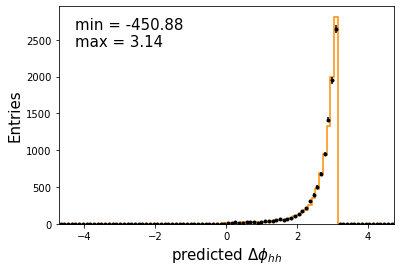

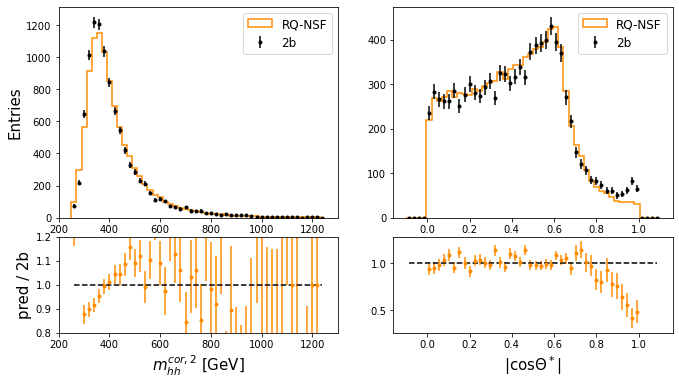

In [22]:
dfj = npj.pred_hh(d.X_SR,d.Y_SR,d.scalar,mask,df,nPreds=nPreds,
                  cols=cols,color='darkorange')

In [23]:
dfi

m_h1        m_h2  log_pT_h1  log_pT_h2    eta_h1  \
samples events                                                           
0       0       130.948105  101.560234   4.192416   4.746469 -0.915966   
        1       129.099579  107.476463   5.033140   4.627624 -0.457780   
        2       123.367012  116.775215   5.371410   4.997552 -0.273261   
        3       112.333488  111.663887   5.060298   4.861992 -0.618761   
        4       130.961731  125.690796   5.038959   4.832544 -0.831746   
...                    ...         ...        ...        ...       ...   
9       10036   108.607925  106.788376   6.100097   5.666050  0.554462   
        10037   130.421402  109.140594   5.486435   5.334497 -0.667352   
        10038   122.491135   96.147995   5.468446   5.163352  0.407960   
        10039   134.279739  111.311584   4.685180   4.188158  2.026613   
        10040   126.378700  101.888878   4.409298   4.178349  0.003463   

                  eta_h2  log_dphi_hh       pT_h1       pT_h2   dphi_hh  \
samples events                                                            
0       0      -1.221005    -1.365592   66.182508  115.176933  2.886363   
        1      -0.299509    -0.868714  153.413932  102.270783  2.722102   
        2      -1.731892    -3.207145  215.166118  148.050276  3.101121   
        3      -0.199543    -2.262014  157.637555  129.281521  3.037452   
        4      -0.009832    -1.105249  154.309299  125.529944  2.810464   
...                  ...          ...         ...         ...       ...   
9       10036   0.904407    -1.425391  445.900888  288.891145  2.901178   
        10037  -1.133937    -1.992168  241.395082  207.368510  3.005193   
        10038   1.311197    -1.494235  237.091527  174.749320  2.917172   
        10039   2.223555     0.302398  108.329739   65.901260  1.788493   
        10040   1.075762    -1.390328   82.211765   65.258024  2.892599   

                      m_hh   m_hh_cor2  absCosThetaStar       pt_hh  
samples events                                                       
0       0       306.331253  323.822914         0.458321   53.798906  
        1       342.074455  355.498413         0.123133   73.050246  
        2       521.802820  531.660593         0.591481   67.503390  
        3       368.983851  394.986476         0.238222   32.013857  
        4       396.752469  390.099942         0.427730   54.155394  
...                    ...         ...              ...         ...  
9       10036   755.403082  790.006781         0.097575  179.057999  
        10037   519.041304  529.479308         0.220079   45.691114  
        10038   500.748451  532.109321         0.397266   77.230083  
        10039   279.538306  283.946982         0.106495  113.993414  
        10040   284.978231  306.710653         0.515223   24.866275  

[100410 rows x 14 columns]

In [24]:
mhh= 'm_hh_cor2'

In [25]:
figDir = 'figures/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut//nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_random_5_layers_H_32_2_blocks_K_8_B_3_lr_0.001_0.001_iter0'

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:27

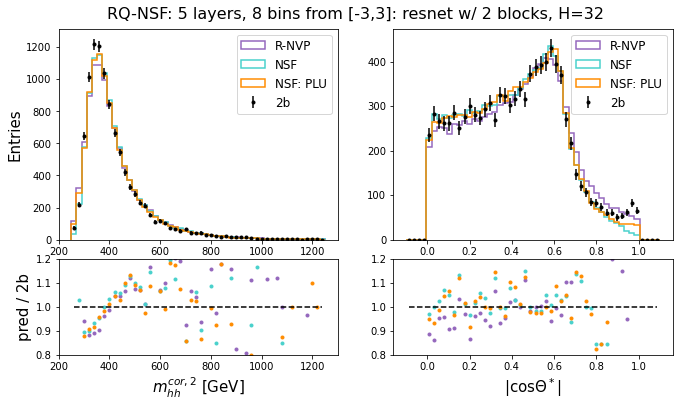

In [26]:
# Make the plot!!
fig = plt.figure(figsize=(11,6))
gs = gridspec.GridSpec(3,2)
ax1a = fig.add_subplot(gs[:2,0])
ax1b = fig.add_subplot(gs[2:,0],sharex=ax1a)

ax2a = fig.add_subplot(gs[:2,1])
ax2b = fig.add_subplot(gs[2:,1],sharex=ax2a)

# Fill in the plots
kwargs = {'histtype':'step','linewidth':1.5}

for i,col,r,axa,axb in zip(range(2),[mhh, 'absCosThetaStar'],[(250,1250),(-.1,1.1)], 
                           [ax1a,ax2a],[ax1b,ax2b]):

    n_2b,e = np.histogram(df.loc[mask,col],50,r)
    xx = 0.5*(e[1:]+e[:-1])

    
    for di,c,l in zip([dfr,dfi,dfj],['C4','mediumturquoise','darkorange'],
                      ['R-NVP','NSF','NSF: PLU']):
        
        n_pred,_,_ = axa.hist(di[col], 50, r,color=c,label=l, 
                              weights=np.ones_like(di[col])/nPreds, 
                              **kwargs)
        
        axb.plot(xx, n_pred/n_2b,color=c,lw=0,marker='.')
        

    axa.errorbar(xx, n_2b, np.sqrt(n_2b), fmt='.', color='k', label='2b')
    axb.plot(xx,np.ones_like(xx),'k--')

    # Make the plot pretty
    axa.legend(loc='upper right',fontsize=12)

ylim=(0.8,1.2)
ax1b.set_ylim(ylim)
ax2b.set_ylim(ylim)

if mhh == 'm_hh': ax1b.set_xlabel('$m_{hh}$ [GeV]',fontsize=15)
if mhh == 'm_hh_cor2': ax1b.set_xlabel('$m_{hh}^{cor,2}$ [GeV]',fontsize=15)
ax2b.set_xlabel('$|\cos \Theta^*|$',fontsize=15)

ax1a.set_ylabel('Entries',fontsize=15)
ax1b.set_ylabel('pred / 2b',fontsize=15);

title = f'RQ-NSF: {L} layers, {K} bins from [-{B},{B}]: resnet w/ {nb} blocks, H={H}'
fig.suptitle(title,y=.93, fontsize=16,va='top')

plt.savefig(f'{figDir}/{mhh}_absCosThetaStar_cf_rnvp_lu.pdf',bbox_inches='tight')

Honestly - at this stage, it's *super* hard to tell the two NSFs apart.

I'll save the figure, but I think this is just going to be one of the hyperparameters that I'm going to need to optimize here.

In [27]:
betaStr=r'$\beta$'

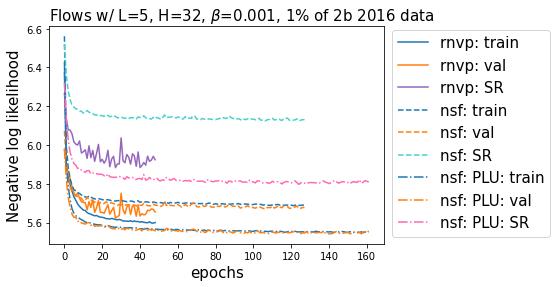

In [28]:
for m,ls,l,c in zip([rmetrics,metrics,metrics2],['-','--','-.'],['rnvp','nsf','nsf: PLU'],
                  ['C4','mediumturquoise','hotpink']):


    plt.plot(m['train_loss'],color='C0',label=f'{l}: train',ls=ls)
    plt.plot(m['val_loss'],color='C1',label=f'{l}: val',ls=ls)
    plt.plot(m['SR_loss'],label=f'{l}: SR',ls=ls,color=c)

    plt.xlabel('epochs',fontsize=15)
    plt.ylabel('Negative log likelihood',fontsize=15)
    plt.legend(fontsize=15,bbox_to_anchor=(1,1.02))
    
plt.title(f'Flows w/ L={L}, H={H}, {betaStr}={beta}, 1% of 2b 2016 data',loc='left',fontsize=15)

plt.savefig(f'{figDir}/loss_cf_rnvp_lu.pdf',bbox_inches='tight')

**Compare trainings with different seeds**

In [29]:
lt,nb,p

('random', 2, 0)

In [30]:
nPreds

10

In [31]:
nSeeds = 100

bins = 50
r1 = (250,1250)
r2 = (200,1200)

In [32]:
lt

'random'

In [33]:
mDict = {}
nDict = {}

for seed in tqdm(range(nSeeds)):
    
    seedTag = f'_seed{seed}' if seed != 10 else ''
    
    nk = myNSF(f'{subDir}{tag}_2b_detaCut{seedTag}', lr,beta,cols,0,L,H,nb,K,B,lt,bt,p,
               modelBaseDir='../Flow-Models/models',torch_seed=seed,debug=False)
    
    filename = f'{nk.modelDir}/loss_acc.json'
    if os.path.exists(filename):

        with open(filename, 'r') as varfile:
            mi = json.load(varfile)
    
        k = f'{lt}_{seed}'
        mDict[k] = mi

        # And retrieve the corresponding df and histograms
        nk = myNSF(f'{subDir}{tag}_2b_detaCut{seedTag}', lr,beta,cols,0,L,H,nb,K,B,lt,bt,p,
                   modelBaseDir='../Flow-Models/models',load_model=True,
                   torch_seed=seed,debug=False) 
        
        npk = RealNVP_Plots(nk,save=False,mode=1)
        
        dfi = npk.pred_hh(d.X_SR,d.Y_SR,d.scalar,mask,df,nPreds=nPreds,cols=cols,plot=False)
        
        # Fill mhhs and |cos(theta*)|
        nDict[f'm_hh_cor2_{k}'] = np.histogram(dfi.m_hh_cor2,bins,r1)[0] / nPreds
        nDict[f'm_hh_{k}'] = np.histogram(dfi.m_hh,bins,r2)[0] / nPreds
        nDict[f'cs_{k}'] = np.histogram(dfi.absCosThetaStar,bins,(0,1))[0] / nPreds

100%|██████████| 100/100 [19:20<00:00, 11.61s/it]


In [34]:
for seed in tqdm(range(nSeeds)):
    
    seedTag = f'_seed{seed}' if seed != 10 else ''
    
    nk = myNSF(f'{subDir}{tag}_2b_detaCut{seedTag}', lr,beta,cols,0,L,H,nb,K,B,'lu',bt,p,
               modelBaseDir='../Flow-Models/models',torch_seed=seed,debug=False)
    
    filename = f'{nk.modelDir}/loss_acc.json'
    if os.path.exists(filename):

        with open(filename, 'r') as varfile:
            mi = json.load(varfile)

        k = f'lu_{seed}'
        mDict[k] = mi
    
        # Now also load in the weights
        nk = myNSF(f'{subDir}{tag}_2b_detaCut{seedTag}', lr,beta,cols,0,L,H,nb,
                   K, B, 'lu', bt ,p, modelBaseDir='../Flow-Models/models',
                   load_model=True,torch_seed=seed,debug=False)
    
        # Predict
        npk = RealNVP_Plots(nk,save=False,mode=1)
        
        dfi = npk.pred_hh(d.X_SR,d.Y_SR,d.scalar,mask,df,nPreds=nPreds,cols=cols,plot=False)
        
        # Fill mhhs and |cos(theta*)|
        nDict[f'm_hh_cor2_{k}'] = np.histogram(dfi.m_hh_cor2,bins,r1)[0] / nPreds
        nDict[f'm_hh_{k}'] = np.histogram(dfi.m_hh,bins,r2)[0] / nPreds
        nDict[f'cs_{k}'] = np.histogram(dfi.absCosThetaStar,bins,(0,1))[0] / nPreds

100%|██████████| 100/100 [23:00<00:00, 13.81s/it]


In [35]:
len(mDict.keys())

200

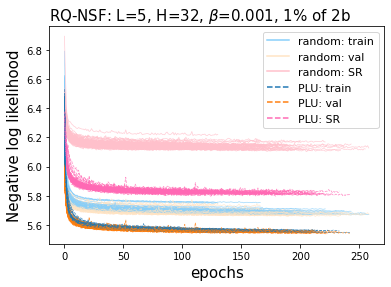

In [36]:
alpha=0.75

for k,m in mDict.items():
    
    ls = '--' if k[:2]=='lu' else '-'
    
    plt.plot(m['train_loss'],color='C0' if k[:2]=='lu' else 'lightskyblue',
             ls=ls,alpha=alpha,lw=0.75)
    plt.plot(m['val_loss'],color='C1' if k[:2]=='lu' else 'bisque',
             ls=ls,alpha=alpha,lw=0.75)
    plt.plot(m['SR_loss'],color='hotpink' if k[:2]=='lu' else 'pink',
             ls=ls,alpha=alpha,lw=0.75)

plt.xlabel('epochs',fontsize=15)
plt.ylabel('Negative log likelihood',fontsize=15);

for l,c in zip(['train','val','SR'],['lightskyblue','bisque','pink']):
    plt.plot([],[],c,label=f'random: {l}')
    
for l,c in zip(['train','val','SR'],['C0','C1','hotpink']):
    plt.plot([],[],c,label=f'PLU: {l}',ls='--')

plt.legend(fontsize=11);
plt.title(f'RQ-NSF: L={L}, H={H}, {betaStr}={beta}, 1% of 2b',loc='left',fontsize=15)

plt.savefig(f'{figDir}/loss_cf_rnvp_varySeeds.pdf',bbox_inches='tight')

But ofc the Q still remains whether I'm benefitting from the better architecture or just the increased number of parameters.

But honestly, I'm trying to do basically engineering rn, not ML architecture design, so even if I only have a slight preference for one over the other, it's fine to pick one sooner rather than later to split my work in half :-)

**Next:** Get predictions for $m_{hh}$ (or $m_{hh}^{cor,2}$) and $|\cos \Theta^*|$ with these two models

**First - just for the model with the random permutaions**

In [37]:
for perm in ['random','lu']:
    for v in ['m_hh_cor2','m_hh','cs']:
        
        k = f'{v}_{perm}'
        
        hists = np.vstack([nDict[f'{k}_{s}'] for s in range(nSeeds) 
                           if f'{k}_{s}' in nDict.keys()])
    
        S = hists.shape[0]
    
        nDict[f'{k}_{S}seeds_mean'] = np.mean(hists,axis=0)
        nDict[f'{k}_{S}seeds_std'] = np.std(hists,axis=0)

        # And then also get some subsamples
        for nsi in [10,25,50,75]:
            nDict[f'{k}_{nsi}seeds_mean'] = np.mean(hists[:nsi],axis=0)
            nDict[f'{k}_{nsi}seeds_std']  = np.std( hists[:nsi],axis=0)
        
    # And how many seeds do we have for this permutation
    print(perm,S,'seeds')

random 100 seeds
lu 100 seeds


In [38]:
nsfTitle = f'RQ-NSF: L={L}, H={H}, {betaStr}={beta}, 1% of 2b'

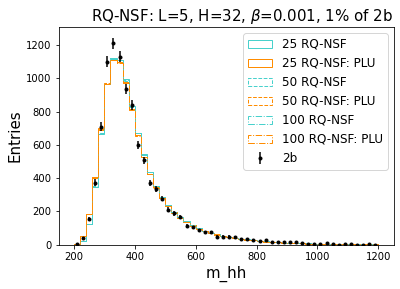

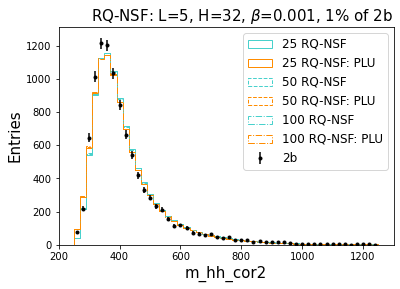

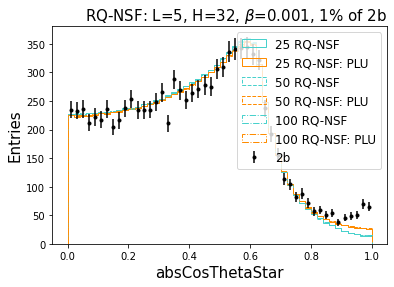

In [39]:
for c,r in zip(['m_hh','m_hh_cor2','absCosThetaStar'],[r2,r1,(0,1)]):

    n_2b,e = np.histogram(df.loc[mask,c],bins,r)
    xx = 0.5 * (e[1:] + e[:-1])
    
    
    plt.figure()
    v = 'cs' if c == 'absCosThetaStar' else c
    
    for ns,ls in zip([25,50,nSeeds],['-','--','-.']):
    
        plt.hist(xx,e,weights=nDict[f'{v}_random_{ns}seeds_mean'],ls=ls,
                 color='mediumturquoise',histtype='step',label=f'{ns} RQ-NSF')
        plt.hist(xx,e,weights=nDict[f'{v}_lu_{ns}seeds_mean'],ls=ls,
                 color='darkorange',histtype='step',label=f'{ns} RQ-NSF: PLU')

    plt.errorbar(xx,n_2b,np.sqrt(n_2b),lw=0,elinewidth=1.5,color='k',
                 label='2b',fmt='.')
    
    plt.xlabel(c,fontsize=15)
    plt.ylabel('Entries',fontsize=15)
    plt.legend(fontsize=12)
    plt.title(nsfTitle,fontsize=15,loc='right')
    
    plt.savefig(f'{figDir}/{c}_mean_varySeeds.pdf',bbox_inches='tight')
    

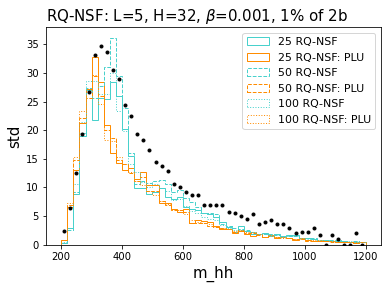

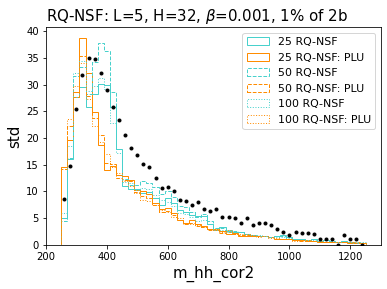

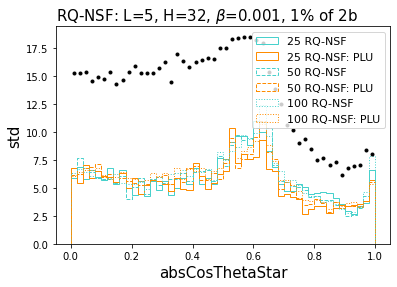

In [40]:
for c,r in zip(['m_hh','m_hh_cor2','absCosThetaStar'],[r2,r1,(0,1)]):

    n_2b,e = np.histogram(df.loc[mask,c],bins,r)
    xx = 0.5 * (e[1:] + e[:-1])
    
    
    plt.figure()
    v = 'cs' if c == 'absCosThetaStar' else c
    
    for ns,ls in zip([25,50,nSeeds],['-','--','dotted']):
        plt.hist(xx,e,weights=nDict[f'{v}_random_{ns}seeds_std'],ls=ls,
                 color='mediumturquoise',histtype='step',label=f'{ns} RQ-NSF')
        plt.hist(xx,e,weights=nDict[f'{v}_lu_{ns}seeds_std'],ls=ls,
                 color='darkorange',histtype='step',label=f'{ns} RQ-NSF: PLU')
    
    plt.xlabel(c,fontsize=15)
    plt.ylabel('std',fontsize=15)
    plt.legend(fontsize=11,loc='upper right')
    plt.title(nsfTitle,fontsize=15,loc='left')
    plt.savefig(f'{figDir}/{c}_std_varySeeds.pdf',bbox_inches='tight')
    
    # Overlay 2b and resave the plot
    plt.plot(xx,np.sqrt(n_2b),lw=0,marker='.',color='k', label='$\sqrt{2b}$')
    plt.savefig(f'{figDir}/{c}_std_varySeeds_2b.pdf',bbox_inches='tight')

Ok - tbh, I'm not really sure what to make of this rn?

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


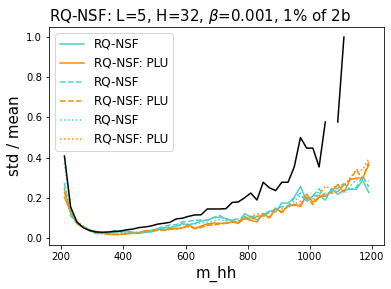

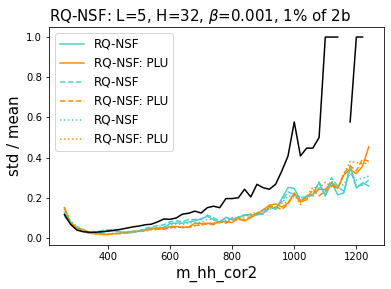

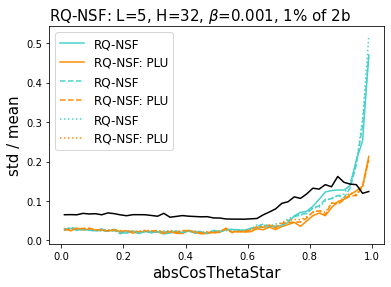

In [41]:
for c,r in zip(['m_hh','m_hh_cor2','absCosThetaStar'],[r2,r1,(0,1)]):

    n_2b,e = np.histogram(df.loc[mask,c],bins,r)
    xx = 0.5 * (e[1:] + e[:-1])
    
    
    plt.figure()
    v = 'cs' if c == 'absCosThetaStar' else c
    for ns,ls in zip([25,50,nSeeds],['-','--','dotted']):
        plt.plot(xx,nDict[f'{v}_random_{ns}seeds_std']/nDict[f'{v}_random_{ns}seeds_mean'],
                 ls=ls,color='mediumturquoise',label='RQ-NSF')
        plt.plot(xx,nDict[f'{v}_lu_{ns}seeds_std']/nDict[f'{v}_lu_{ns}seeds_mean'],
                 ls=ls,color='darkorange',label='RQ-NSF: PLU')

    plt.xlabel(c,fontsize=15)
    plt.ylabel('std / mean',fontsize=15)
    plt.legend(fontsize=12)
    plt.title(nsfTitle,fontsize=15,loc='left')
    plt.savefig(f'{figDir}/{c}_std_mean_varySeeds.pdf',bbox_inches='tight')
    
    plt.plot(xx,np.sqrt(n_2b)/n_2b,color='k', label='2b')
    plt.savefig(f'{figDir}/{c}_std_mean_varySeeds_2b.pdf',bbox_inches='tight')

In [42]:
npj.figDir

'figures/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut//nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_5_layers_H_32_2_blocks_K_8_B_3_lr_0.001_0.001_iter0/'

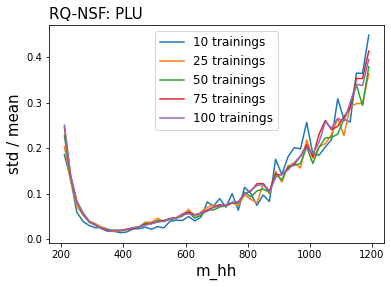

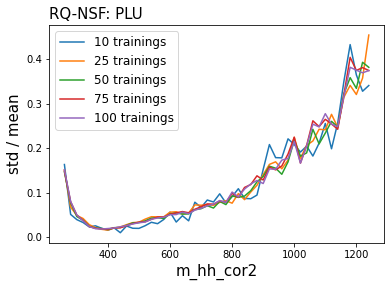

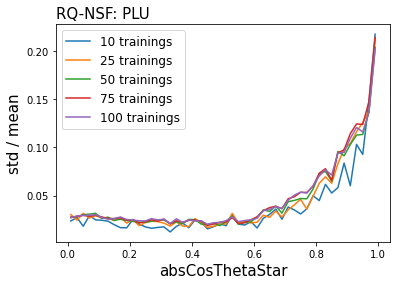

In [43]:
for c,r in zip(['m_hh','m_hh_cor2','absCosThetaStar'],[r2,r1,(0,1)]):

    n_2b,e = np.histogram(df.loc[mask,c],bins,r)
    xx = 0.5 * (e[1:] + e[:-1])
    
    plt.figure()
    v = 'cs' if c == 'absCosThetaStar' else c
    for ns in [10,25,50,75,nSeeds]:
        plt.plot(xx,nDict[f'{v}_lu_{ns}seeds_std']/nDict[f'{v}_lu_{ns}seeds_mean'],
                 label=f'{ns} trainings')

    plt.xlabel(c,fontsize=15)
    plt.ylabel('std / mean',fontsize=15)
    plt.title('RQ-NSF: PLU',fontsize=15,loc='left')
    plt.legend(fontsize=12)
    
    plt.savefig(f'{npj.figDir}/{c}_std_mean_varySeeds.pdf',bbox_inches='tight')

Ok - so they're a little noisy rn, and I think that means I should submit *more trainings*, but let's just step back maybe now, and take a second to get the same "message plots" that I've been looking @ before.

Maybe - if they look reasonable, I might try w/ fewer seeds?

In [44]:
def compare2b(nom,std,col,df,mask,bins=50,r=(0,1),
              c0='paleturquoise',c1='teal',log=False,xlabel=''):
    '''
    Just get the "message plots"
    '''
    
    # Make the figure
    fig = plt.figure(figsize=(11,6))
    gs = gridspec.GridSpec(3,2)
    ax1 = fig.add_subplot(gs[:2,0])
    ax2 = fig.add_subplot(gs[2:,0],sharex=ax1)


    n_2b,e = np.histogram(df.loc[mask,col],bins,r)
    xx = 0.5 * ( e[1:] + e[:-1] )

    # # Error bars w/ central value
    ax1.fill_between(xx, nom+std, nom-std, ec=c0,fc=c0,zorder=0,step='mid')
    ax2.fill_between(xx, (nom+std)/nom, (nom-std)/nom, ec=c0,fc=c0,zorder=0,step='mid')
    ax1.hist(xx, bins,r,color=c1,histtype='step',weights=nom,label='RQ-NSF')

    # 2b
    ax1.errorbar(xx,n_2b,np.sqrt(n_2b),lw=0,elinewidth=1.5,color='k',
                 label='2b',fmt='.')
    ax2.errorbar(xx,n_2b/nom,np.sqrt(n_2b)/nom,lw=0,elinewidth=1.5,color='k',fmt='.')
    
    if log:
        ax1.set_yscale('log')

    ax2.plot(xx, np.ones_like(xx), color='k',linestyle='--')

    ax1.set_ylabel('Entries',fontsize=15)
    ax1.legend(fontsize=12)#,bbox_to_anchor=(1,1.03))
    #ax1.set_title(title,loc='right',fontsize=15 if len(title) < 10 else 12)

    ax2.set_xlabel(xlabel if len(xlabel) > 0 else col, fontsize=15)
    ax2.set_ylim(0,2)
    ax2.set_ylabel('2b / pred',fontsize=15)

    # ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes)
    # ax1.text(0.1, 0.05, f'{p*100:1.0f}% of the 2b data\n{nSeeds} seeds, {betaStr}={beta:1.0e}\nR-NVP w/ {varTag}',
    #          ha='left',va='bottom',transform=ax1.transAxes,fontsize=15)




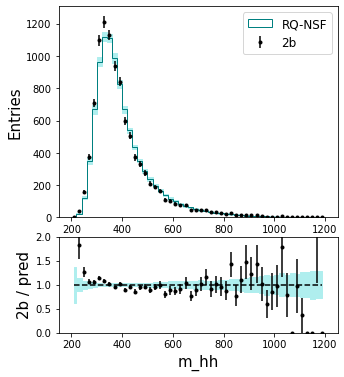

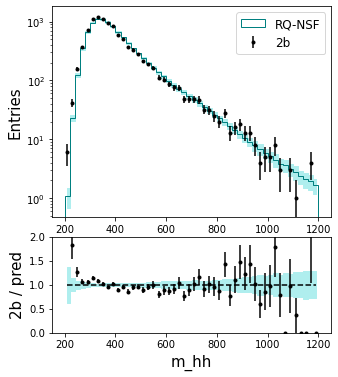

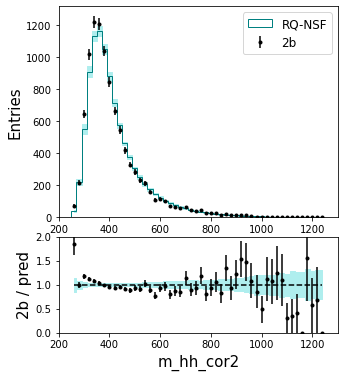

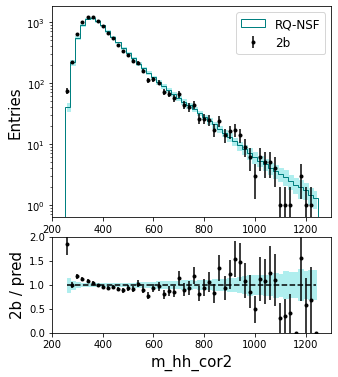

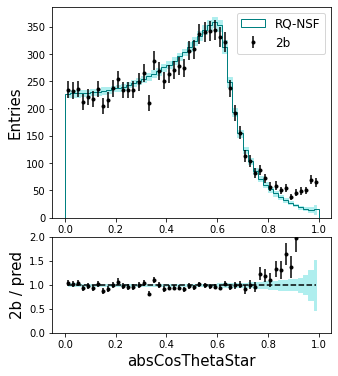

In [45]:
for col,r in zip(['m_hh','m_hh_cor2','absCosThetaStar'],[r2,r1,(0,1)]):

    v = 'cs' if col == 'absCosThetaStar' else col
    logs = [False,True] if v != 'cs' else [False]
    for log in logs:
        compare2b(nDict[f'{v}_random_{ns}seeds_mean'],
                  nDict[f'{v}_random_{ns}seeds_std'],
                  col,df,mask,r=r,log=log)

I don't know what the issue is, but in terms of the $m_{hh}$ distributions - they really don't seem as good.



**And now for the PLU permuations - since they seem a bit more stable in terms of training**

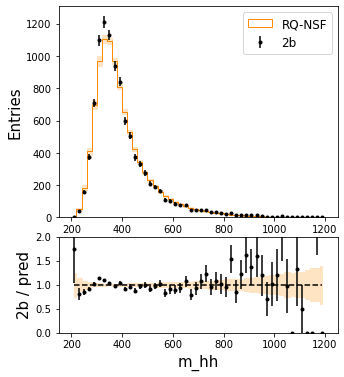

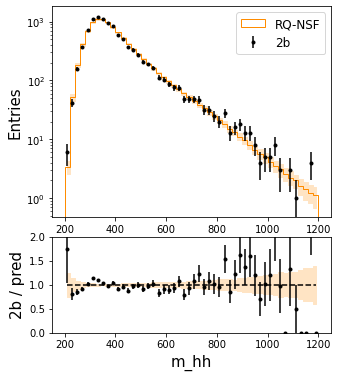

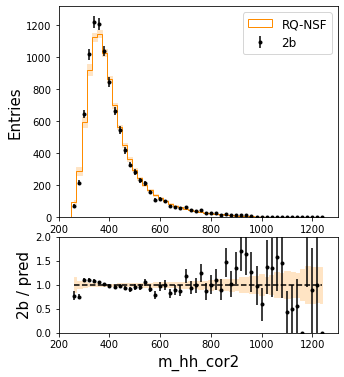

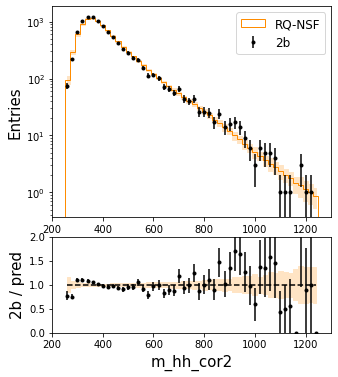

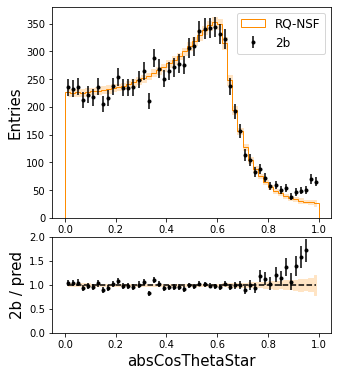

In [46]:
for col,r in zip(['m_hh','m_hh_cor2','absCosThetaStar'],[r2,r1,(0,1)]):

    v = 'cs' if col == 'absCosThetaStar' else col
    logs = [False,True] if v != 'cs' else [False]
    for log in logs:
        compare2b(nDict[f'{v}_lu_{ns}seeds_mean'],
                  nDict[f'{v}_lu_{ns}seeds_std'],
                  col,df,mask,r=r,c0='bisque',c1='darkorange',log=log)

Alright - so I wasn't 100% sure, but Sean linked me to [this talk](https://indico.cern.ch/event/860285/contributions/3623891/attachments/1935826/3207873/Bootstrap_Optimization.pdf) he had for his choice of 100 bootstraps, so maybe I'll j try to reprocduce a few of his metrics now.

In [47]:
text = "$\mathbf{ATLAS}$ data Internal\n"
text += "2016 data FEB2020 MNT prod\n"
text += "DL1r 77% WP, $\mathrm{\mathbb{P}}_{SM},|\Delta \eta_{hh}|$ < 1.5"

In [48]:
dfis = []

for seed in tqdm(range(nSeeds)):
    
    seedTag = f'_seed{seed}' if seed != 10 else ''
    
    nk = myNSF(f'{subDir}{tag}_2b_detaCut{seedTag}', lr,beta,cols,0,L,H,nb,K,B,'lu',bt,p,
               modelBaseDir='../Flow-Models/models',torch_seed=seed,debug=False)
    
    filename = f'{nk.modelDir}/loss_acc.json'
    if os.path.exists(filename):

        with open(filename, 'r') as varfile:
            mi = json.load(varfile)

        k = f'lu_{seed}'
        mDict[k] = mi
    
        # Now also load in the weights
        nk = myNSF(f'{subDir}{tag}_2b_detaCut{seedTag}', lr,beta,cols,0,L,H,nb,
                   K, B, 'lu', bt ,p, modelBaseDir='../Flow-Models/models',
                   load_model=True,torch_seed=seed,debug=False)
    
        # Predict
        npk = RealNVP_Plots(nk,save=False,mode=1)
        
        dfi = npk.pred_hh(d.X_SR[:100],d.Y_SR[:100],d.scalar,mask,df,nPreds=nPreds,cols=cols,plot=False)
        # I think it makes more sense here to keep dfi with same (events, samples / event)
        dfi = dfi.swaplevel()
        
        dfis.append(dfi)

100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


In [49]:
d.X_SR[0],d.Y_SR[0]

(tensor([ 0.3309, -0.1353]),
 tensor([-0.7999,  0.2872,  1.3256,  0.8249,  1.1891]))

In [50]:
d.df[(df.kinematic_region==0) & (df.abs_deta_hh < 1.5)]

entry  run_number  event_number  mc_sf  ntag  njets  \
8760541   716032      303266    1281149719      1     2      5   
2232599   179567      307935    2585272354      1     2      4   
10353248  775990      302956    3442982741      1     2      4   
1377486   290707      311365     767735003      1     2      4   
12600447   69148      307259     595771815      1     2      5   
...          ...         ...           ...    ...   ...    ...   
9859551   530856      311321    1805369740      1     2      5   
2787140     1281      301932    2029870264      1     2      5   
7272113   256858      303499    3521695080      1     2      4   
1953066   316361      303304     519389159      1     2      4   
4299901   326123      306278    3583336903      1     2      5   

          kinematic_region        m_hh       pt_hh      X_wt  ...  \
8760541                  0  328.949472  114.260672  2.204451  ...   
2232599                  0  350.001239   22.513238  2.037233  ...   
10353248                 0  381.310657   87.859657  2.615670  ...   
1377486                  0  431.865556   80.517024  4.328870  ...   
12600447                 0  386.610843  116.514322  3.330214  ...   
...                    ...         ...         ...       ...  ...   
9859551                  0  262.675510   75.363609  0.772996  ...   
2787140                  0  308.777812   93.409724  2.738897  ...   
7272113                  0  319.708492   72.758562  1.522774  ...   
1953066                  0  297.229451   31.411864  2.786632  ...   
4299901                  0  336.382009   93.012592  2.271351  ...   

          log_m_hh_cor2  abs_deta_hh  absCosThetaStar  log_pT_h1  log_pT_h2  \
8760541        4.568933     0.623107         0.215630   4.667170   4.948531   
2232599        4.731144     1.207837         0.589541   4.659411   4.643242   
10353248       4.949954     1.138527         0.515436   4.732417   4.999521   
1377486        5.336904     0.019084         0.084881   5.333096   5.137777   
12600447       4.867214     0.818904         0.301132   5.297058   4.471604   
...                 ...          ...              ...        ...        ...   
9859551        3.856071     1.430920         0.971249   4.075285   3.123779   
2787140        4.237229     0.755256         0.125458   4.989772   4.038228   
7272113        4.615807     0.795009         0.401300   4.681784   4.744556   
1953066        3.944260     0.768314         0.663310   4.339141   4.028255   
4299901        4.683190     0.407545         0.302288   4.860283   4.811385   

           dphi_hh  log_dphi_hh  train    val   test  
8760541   2.220079    -0.081737  False  False  False  
2232599   2.926812    -1.538137  False  False  False  
10353248  2.509489    -0.458702  False  False  False  
1377486   2.757765    -0.957561  False  False  False  
12600447  2.904819    -1.440652  False  False  False  
...            ...          ...    ...    ...    ...  
9859551   0.883715     0.814425  False  False  False  
2787140   2.873932    -1.318034  False  False  False  
7272113   2.479488    -0.412332  False  False  False  
1953066   2.776526    -1.007675  False  False  False  
4299901   2.386905    -0.281451  False  False  False  

[10041 rows x 51 columns]

In [51]:
m_hhs = d.df.loc[(df.kinematic_region==0) & (df.abs_deta_hh < 1.5),'m_hh'].values
cosThetas = d.df.loc[(df.kinematic_region==0) & (df.abs_deta_hh < 1.5),'absCosThetaStar'].values

In [ ]:
dfi.loc[11]

In [53]:
def evtPreds(true_val, dfis, ievt, col, nb,r, text='',title='',xlabel='',figDir=''):
    '''
    Goal: Visualize the variation of a single event for these conditional flows
    
    Inputs:
    - true_val: The true value for this point in the SR
    - dfis: List of MultiIndex dfs indexed by (events,preds) for the
            predictions of the model
    - ievt: The event to evaluate the variation of predictions over
    - col: The col of dfis to evaluate
    - nb, r: The number of bins and range to consider
    
    - text: Data description for the upper left corner
    - title: title (upper right)
    - xlabel: xlabel if not an empty string. If an empty string is passed, 
              the col will just be used for the xlabel
            
    - figDir: If not an empty string, the file to save this to
    
    Rn the variation will be compared for
    1. All 100 seeds w/ all 10 preds
    2. 25 seeds w/ all 10 preds
    3. All 100 seeds w/ all 2 preds
    
    '''
    
    v0s = np.hstack([dfi.loc[ievt,col].values for dfi in dfis])
    v1s = np.hstack([dfi.loc[ievt,col].values for dfi in dfis[:25]])
    v2s = np.hstack([dfi.loc[ievt,col].values[:2] for dfi in dfis])

    nSeeds = len(dfis)
    nPreds = len(dfis[0].loc[ievt,col].values)
    
    plt.hist(v0s,nb,r,histtype='step',lw=1.5,density=True, label=f'{nSeeds} seeds, {nPreds} preds')
    plt.hist(v1s,nb,r,histtype='step',lw=1.5,density=True, label=f'25 seeds, {nPreds} preds')
    plt.hist(v2s,nb,r,histtype='step',lw=1.5,density=True, label=f'{nSeeds} seeds, 2 preds')

    plt.xlabel(xlabel if len(xlabel) > 0 else col, fontsize=15)
    plt.ylabel('Normalized entries',fontsize=15)
    plt.legend(fontsize=11,loc='upper right')
    plt.title(title,fontsize=15,loc='right')

    _,ymax = plt.ylim()
    plt.ylim(0,1.3*ymax)

    ylim = plt.ylim()
    plt.plot([true_val]*2,ylim,'k--')
    plt.ylim(ylim)

    ax = plt.gca()
    ax.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)

    varText = col if len(xlabel) == 0 else xlabel.split(' ')[0]
    varText += f' = {true_val:.2f}'
    if xlabel[-5:]=='[GeV]': varText += ' GeV'
    #varText += f'\n ($m_1,m_2$) = ({:.0f},{:.0f})'
    
    props = dict(facecolor='white', alpha=0.8) 
    ax.text(.03,.95,varText, ha='left',va='top',
            fontsize=15,transform=ax.transAxes,bbox=props)

    if len(figDir) > 0:
        plt.savefig(f'{figDir}/{col}_{ievt}.pdf',bbox_inches='tight')
    plt.show()

In [54]:
evtDir = npj.figDir+'events'
nx = 25
trTitle = 'train on 1% of 2b'

In [55]:
dfi.index

MultiIndex([( 0, 0),
            ( 1, 0),
            ( 2, 0),
            ( 3, 0),
            ( 4, 0),
            ( 5, 0),
            ( 6, 0),
            ( 7, 0),
            ( 8, 0),
            ( 9, 0),
            ...
            (90, 9),
            (91, 9),
            (92, 9),
            (93, 9),
            (94, 9),
            (95, 9),
            (96, 9),
            (97, 9),
            (98, 9),
            (99, 9)],
           names=['events', 'samples'], length=1000)

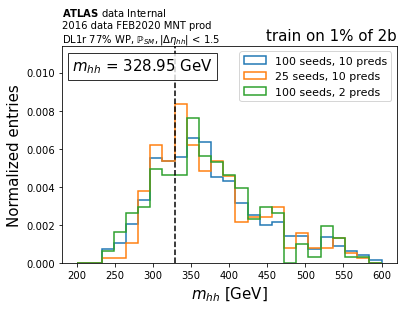

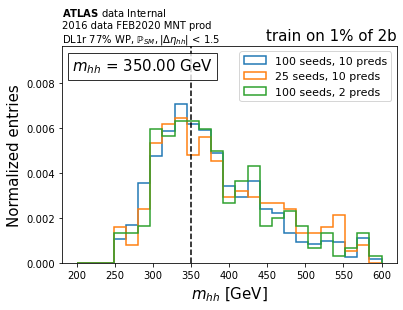

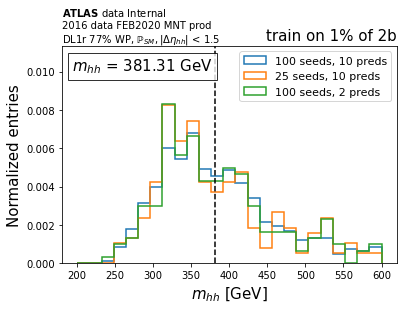

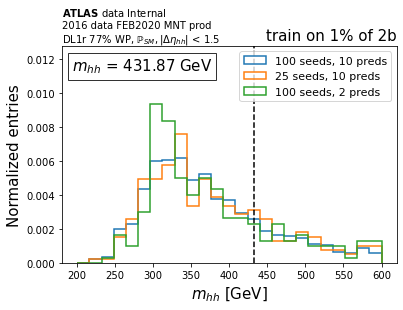

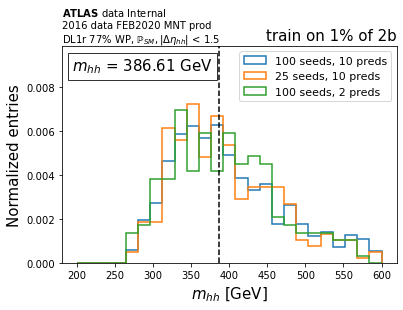

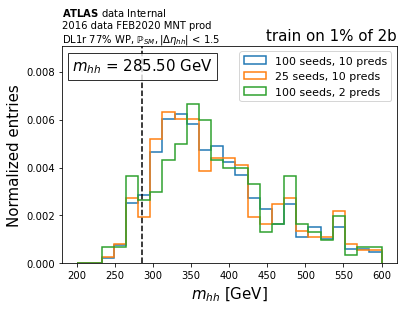

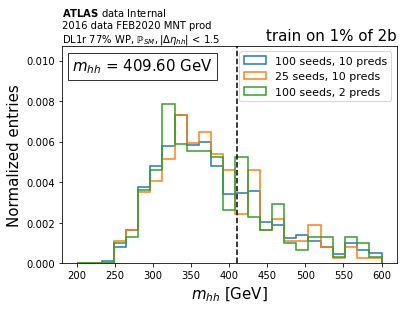

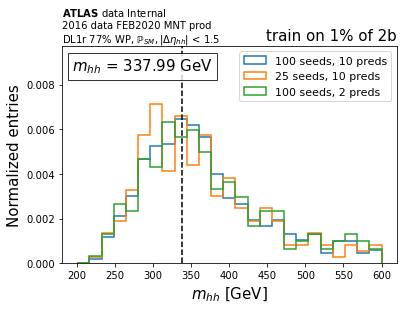

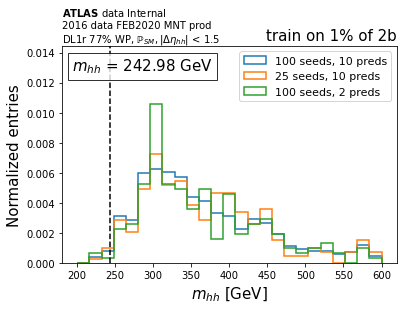

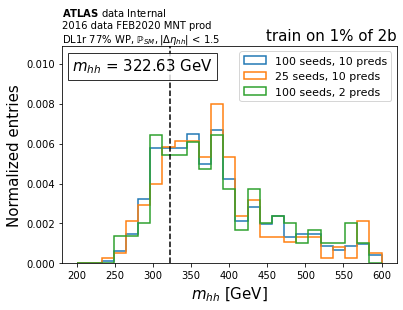

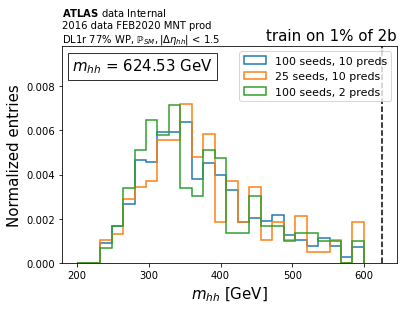

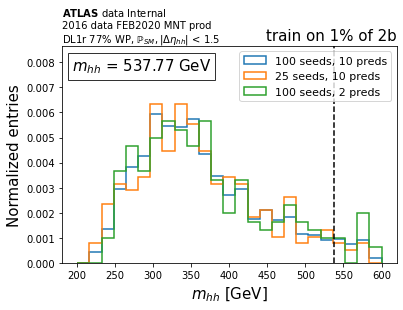

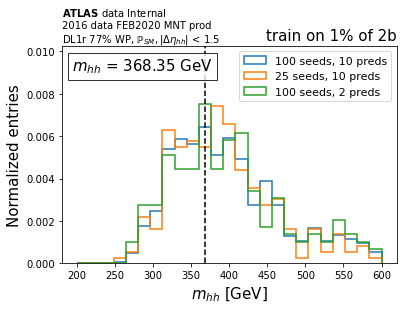

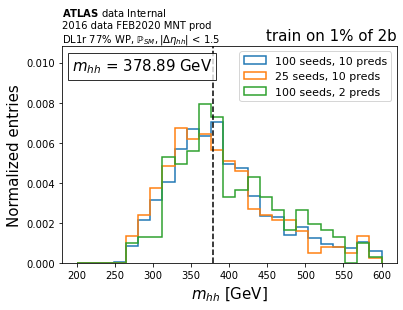

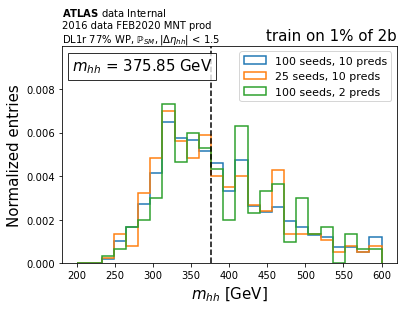

In [56]:
for ievt, m_hh in enumerate(m_hhs[:15]):

    evtPreds(m_hh, dfis, ievt, 'm_hh', nx, (200,600), text=text,
             title=trTitle,xlabel='$m_{hh}$ [GeV]', figDir=evtDir)


But remember, the only conditioning that I put in the model is w/r.t. $m_{h1},m_{h2}$.
Since is was a little complicated to put this on the plot as well, I decided just to print it out.

In [57]:
m_h1s = d.df.loc[(df.kinematic_region==0) & (df.abs_deta_hh < 1.5),'m_h1'].values
m_h2s = d.df.loc[(df.kinematic_region==0) & (df.abs_deta_hh < 1.5),'m_h2'].values

for i,mh1,mh2 in zip(range(15),m_h1s,m_h2s):
    print(f'{ i:2d}. ({ mh1:3.1f},{ mh2:3.1f}) GeV')

 0. (130.9,101.6) GeV
 1. (129.1,107.5) GeV
 2. (123.4,116.8) GeV
 3. (112.3,111.7) GeV
 4. (131.0,125.7) GeV
 5. (130.3,104.5) GeV
 6. (132.6,101.9) GeV
 7. (123.3,98.0) GeV
 8. (111.2,105.5) GeV
 9. (130.5,106.1) GeV
10. (117.3,109.8) GeV
11. (117.5,98.8) GeV
12. (132.6,120.5) GeV
13. (135.2,118.0) GeV
14. (116.5,119.2) GeV


Since it doesn't seem like I had any variation in the $|\cos\Theta *|$ plots based on individual events, I'll just make a little for loop to scan over some of these

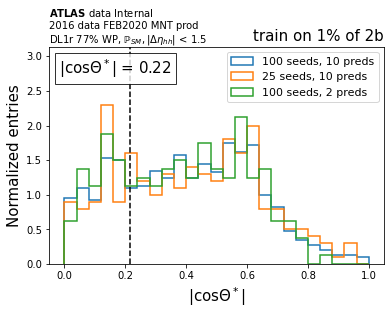

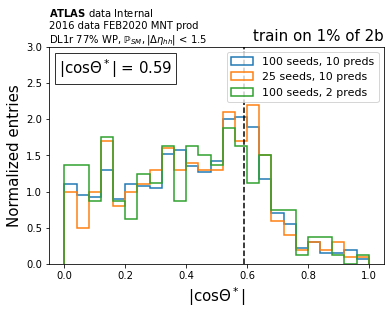

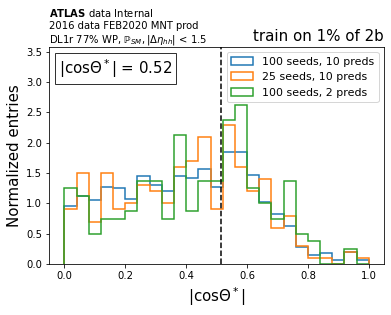

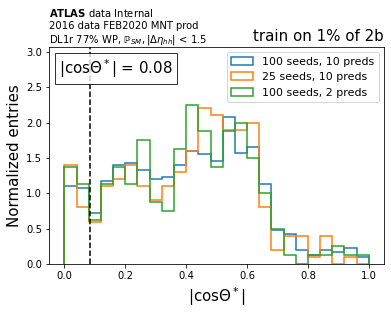

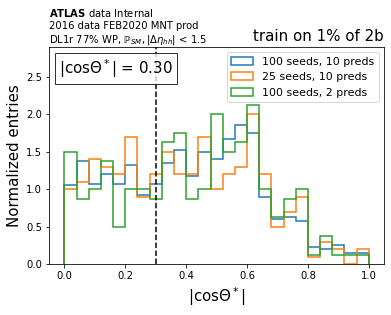

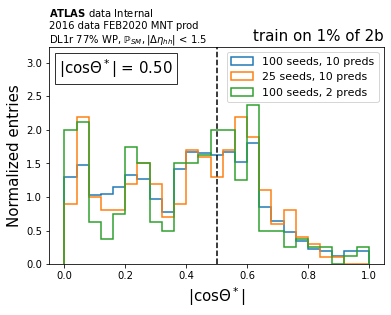

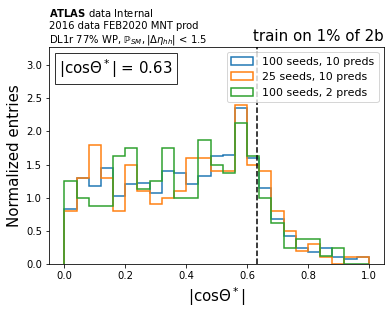

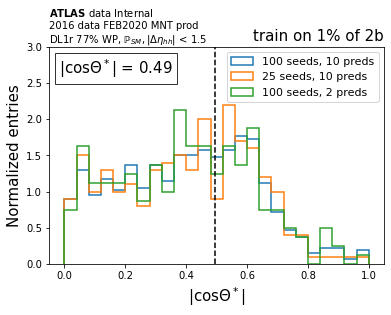

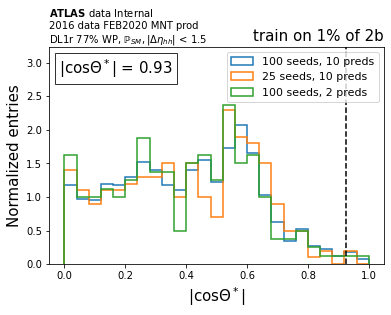

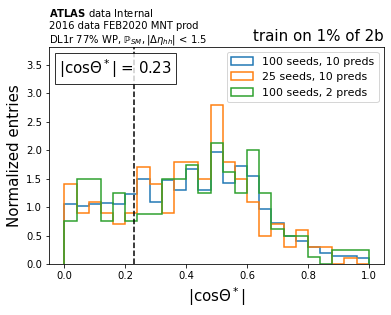

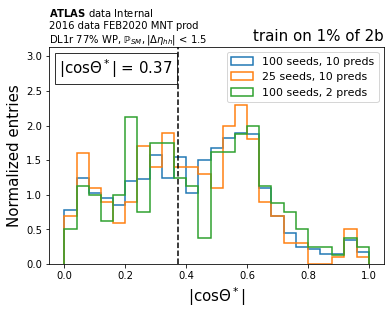

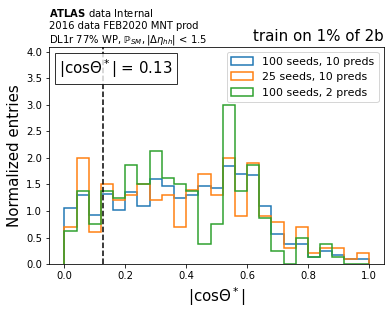

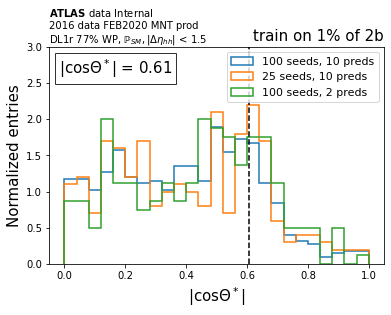

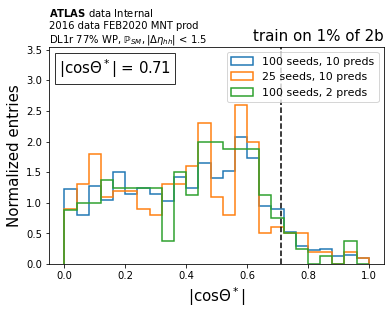

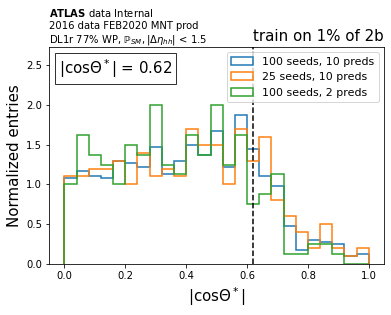

In [58]:
for ievt, cosTheta in enumerate(cosThetas[:15]):
    evtPreds(cosTheta, dfis, ievt, 'absCosThetaStar', nx, (0,1), text=text,
             title=trTitle,xlabel='$|\cos\Theta^*|$', figDir=evtDir)

**Question from Michael:** Is there any variationn between the predictions based on where we are in the massplane?

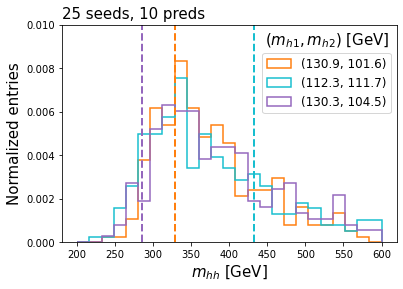

In [103]:
# Compare mhh

# events 0, 3, 5

for ievt,c in zip([0,3,5],['C1','C9','C4']):
    
    mhh = m_hhs[ievt]
    plt.plot([mhh]*2,[0,0.01],c,ls='--',lw=2)

    vs = np.hstack([dfi.loc[ievt,'m_hh'].values for dfi in dfis[:25]])

    plt.hist(vs, nx, (200,600), color=c, histtype='step', lw=1.5, density=True, 
             label=f'({m_h1s[ievt]:.1f}, {m_h2s[ievt]:.1f})')
      
plt.xlabel('$m_{hh}$ [GeV]',fontsize=15)
plt.ylabel('Normalized entries',fontsize=15)
plt.title(f'25 seeds, {nPreds} preds',fontsize=15,loc='left')
ax = plt.gca()
plt.text(.98,.97,'($m_{h1}, m_{h2}$) [GeV]',ha='right',va='top',transform=ax.transAxes,fontsize=15)
plt.legend(fontsize=12,bbox_to_anchor=(1,.9),loc='upper right')
plt.ylim(0,.01)

plt.savefig(f'{evtDir}/m_hh_25seeds_evt_0_3_5.pdf',bbox_inches='tight')

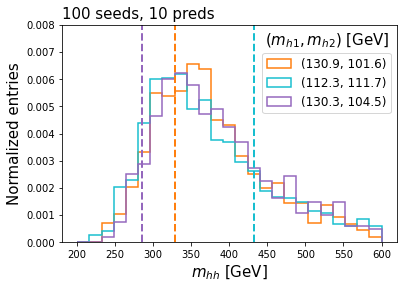

In [102]:
# Compare mhh on events 0, 3, 5

ymax = .008

for ievt,c in zip([0,3,5],['C1','C9','C4']):
    
    mhh = m_hhs[ievt]
    plt.plot([mhh]*2,[0,ymax],c,ls='--',lw=2)

    vs = np.hstack([dfi.loc[ievt,'m_hh'].values for dfi in dfis])

    plt.hist(vs, nx, (200,600), color=c, histtype='step', lw=1.5, density=True, 
             label=f'({m_h1s[ievt]:.1f}, {m_h2s[ievt]:.1f})')
      
plt.xlabel('$m_{hh}$ [GeV]',fontsize=15)
plt.ylabel('Normalized entries',fontsize=15)
plt.title(f'{nSeeds} seeds, {nPreds} preds',fontsize=15,loc='left')
ax = plt.gca()
plt.text(.98,.97,'($m_{h1}, m_{h2}$) [GeV]',ha='right',va='top',transform=ax.transAxes,fontsize=15)
plt.legend(fontsize=12,bbox_to_anchor=(1,.9),loc='upper right')
plt.ylim(0,ymax)

plt.savefig(f'{evtDir}/m_hh_{nSeeds}seeds_evt_0_3_5.pdf',bbox_inches='tight')

**Next:** For $|\cos \Theta^*|$

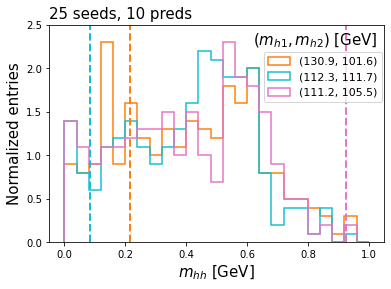

In [104]:
# Compare cos(theta*) foer events 0, 3, 8

ymax = 2.5
for ievt,c in zip([0,3,8],['C1','C9','C6']):
    
    cst = cosThetas[ievt]
    plt.plot([cst]*2,[0,ymax],c,ls='--',lw=2)

    vs = np.hstack([dfi.loc[ievt,'absCosThetaStar'].values for dfi in dfis[:25]])

    plt.hist(vs, nx, (0,1), color=c, histtype='step', lw=1.5, density=True, 
             label=f'({m_h1s[ievt]:.1f}, {m_h2s[ievt]:.1f})')
      
plt.xlabel('$m_{hh}$ [GeV]',fontsize=15)
plt.ylabel('Normalized entries',fontsize=15)
plt.title(f'25 seeds, {nPreds} preds',fontsize=15,loc='left')
ax = plt.gca()
plt.text(.98,.97,'($m_{h1}, m_{h2}$) [GeV]',ha='right',va='top',transform=ax.transAxes,fontsize=15)
plt.legend(fontsize=11,bbox_to_anchor=(1.01,.9),loc='upper right')
plt.ylim(0,ymax)

plt.savefig(f'{evtDir}/absCosThetaStar_25seeds_evt_0_3_8.pdf',bbox_inches='tight')

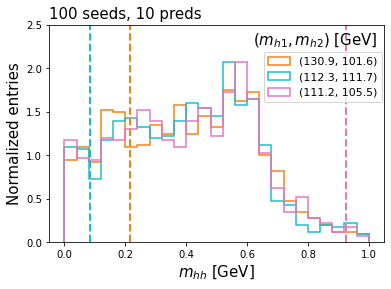

In [105]:
# Compare cos(theta*) foer events 0, 3, 8

ymax = 2.5
for ievt,c in zip([0,3,8],['C1','C9','C6']):
    
    cst = cosThetas[ievt]
    plt.plot([cst]*2,[0,ymax],c,ls='--',lw=2)

    vs = np.hstack([dfi.loc[ievt,'absCosThetaStar'].values for dfi in dfis])

    plt.hist(vs, nx, (0,1), color=c, histtype='step', lw=1.5, density=True, 
             label=f'({m_h1s[ievt]:.1f}, {m_h2s[ievt]:.1f})')
      
plt.xlabel('$m_{hh}$ [GeV]',fontsize=15)
plt.ylabel('Normalized entries',fontsize=15)
plt.title(f'{nSeeds} seeds, {nPreds} preds',fontsize=15,loc='left')
ax = plt.gca()
plt.text(.98,.97,'($m_{h1}, m_{h2}$) [GeV]',ha='right',va='top',transform=ax.transAxes,fontsize=15)
plt.legend(fontsize=11,bbox_to_anchor=(1.01,.9),loc='upper right')
plt.ylim(0,ymax)

plt.savefig(f'{evtDir}/absCosThetaStar_{nSeeds}seeds_evt_0_3_8.pdf',bbox_inches='tight')

**Variation of the error bands**

This was one of the last metrics that Sean looked at, so I want to check it out as well :)

In [106]:
mhh_hists = [nDict[k] for k in[f'm_hh_lu_{s}' for s in range(nSeeds)]]

In [107]:
from random import choices

In [108]:
stds_25 = []

for i in range(100):
    stds_25.append(np.std(np.vstack(choices(mhh_hists,k=25)),axis=0))

stds_25 = np.vstack(stds_25)
mean_std_25 = np.mean(stds_25,axis=0) 
std_std_25  = np.std( stds_25,axis=0) 


In [109]:
stds_50 = []

for i in range(100):
    stds_50.append(np.std(np.vstack(choices(mhh_hists,k=50)),axis=0))

stds_50 = np.vstack(stds_50)
mean_std_50 = np.mean(stds_50,axis=0) 
std_std_50  = np.std( stds_50,axis=0) 

In [110]:
stds_100 = []

for i in range(100):
    stds_100.append(np.std(np.vstack(choices(mhh_hists,k=100)),axis=0))

stds_100 = np.vstack(stds_100)
mean_std_100 = np.mean(stds_100,axis=0) 
std_std_100  = np.std( stds_100,axis=0) 


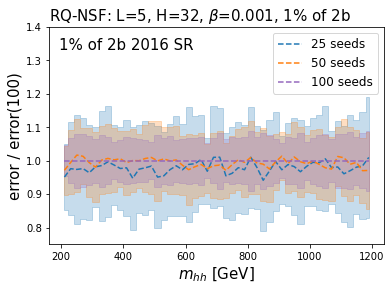

In [111]:
e = np.linspace(*r2,bins+1)
xx = 0.5*(e[1:]+e[:-1])
alpha = 0.25

plt.plot(xx,mean_std_25/mean_std_100,color='C0',ls='--',label='25 seeds')
plt.plot(xx,mean_std_50/mean_std_100,color='C1',ls='--',label='50 seeds')
plt.plot(xx,mean_std_100/mean_std_100,color='C4',ls='--',label='100 seeds')

plt.fill_between(xx,(mean_std_25+std_std_25)/mean_std_100,(mean_std_25-std_std_25)/mean_std_100,
                 step='mid',color='C0',alpha=alpha)
plt.fill_between(xx,(mean_std_50+std_std_50)/mean_std_100,(mean_std_50-std_std_50)/mean_std_100,
                 step='mid',color='C1',alpha=alpha)
plt.fill_between(xx,(mean_std_100+std_std_100)/mean_std_100,(mean_std_100-std_std_100)/mean_std_100,
                 step='mid',color='C4',alpha=alpha)


plt.legend(fontsize=12)
plt.xlabel('$m_{hh}$ [GeV]',fontsize=15)
plt.ylabel('error / error(100)',fontsize=15)

plt.ylim(.75,1.4)

ax = plt.gca()
plt.text(.03,.95,'1% of 2b 2016 SR',ha='left',va='top',fontsize=15,transform=ax.transAxes)
plt.title(nsfTitle,loc='left',fontsize=15)

plt.savefig(f'{npj.figDir}/mhh_std_of_std_varySeeds.pdf',bbox_inches='tight')
plt.show()

For completeness, let's look at $|\cos \Theta^*|$ as well.

In [112]:
cs_hists = [nDict[k] for k in[f'cs_lu_{s}' for s in range(nSeeds)]]

stds_25 = []
for i in range(100):
    stds_25.append(np.std(np.vstack(choices(cs_hists,k=25)),axis=0))

stds_25 = np.vstack(stds_25)
mean_std_25 = np.mean(stds_25,axis=0) 
std_std_25  = np.std( stds_25,axis=0) 


stds_50 = []

for i in range(100):
    stds_50.append(np.std(np.vstack(choices(cs_hists,k=50)),axis=0))

stds_50 = np.vstack(stds_50)

mean_std_50 = np.mean(stds_50,axis=0) 
std_std_50  = np.std( stds_50,axis=0) 

stds_100 = []

for i in range(100):
    stds_100.append(np.std(np.vstack(choices(cs_hists,k=100)),axis=0))

stds_100 = np.vstack(stds_100)

mean_std_100 = np.mean(stds_100,axis=0) 
std_std_100  = np.std( stds_100,axis=0) 

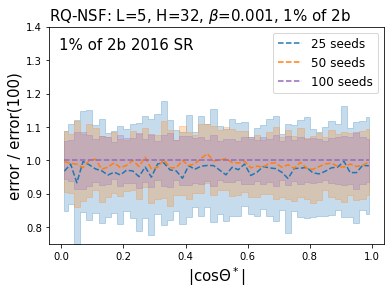

In [113]:
ey = np.linspace(0,1,bins+1)
yy = 0.5*(ey[1:]+ey[:-1])

plt.plot(yy,mean_std_25/mean_std_100,color='C0',ls='--',label='25 seeds')
plt.plot(yy,mean_std_50/mean_std_100,color='C1',ls='--',label='50 seeds')
plt.plot(yy,mean_std_100/mean_std_100,color='C4',ls='--',label='100 seeds')

plt.fill_between(yy,(mean_std_25+std_std_25)/mean_std_100,(mean_std_25-std_std_25)/mean_std_100,
                 step='mid',color='C0',alpha=alpha)
plt.fill_between(yy,(mean_std_50+std_std_50)/mean_std_100,(mean_std_50-std_std_50)/mean_std_100,
                 step='mid',color='C1',alpha=alpha)
plt.fill_between(yy,(mean_std_100+std_std_100)/mean_std_100,(mean_std_100-std_std_100)/mean_std_100,
                 step='mid',color='C4',alpha=alpha)


plt.legend(fontsize=12)
plt.xlabel('$|\cos \Theta^*|$',fontsize=15)
plt.ylabel('error / error(100)',fontsize=15)

plt.ylim(.75,1.4)

ax = plt.gca()
plt.text(.03,.95,'1% of 2b 2016 SR',ha='left',va='top',fontsize=15,transform=ax.transAxes)
plt.title(nsfTitle,loc='left',fontsize=15)

plt.savefig(f'{npj.figDir}/absCosThetaStar_std_of_std_varySeeds.pdf',bbox_inches='tight')
plt.show()